In [ ]:
# 代码来源
# https://mp.weixin.qq.com/s/6vkz18Xw4USZ3fldd_wf5g



# 二、文本表示方法
### 在自然语言领域，因为文本的长度是不固定的。文本分类的第一步就是将不定长的文本转换到定长的空间内，即词嵌入。
## 2.1 One-hot
### One-hot方法将每一个$\pmb{单词}$使用一个离散的向量表示，将每个$\pmb{字/词}$编码成一个索引，然后根据索引进行赋值。One-hot表示法的一个例子如下：



## 2.2 Bags of Words
### Bags of Words，也称为Count Vectors，统计每个$\pmb{文档}$的字/词可以使用其出现次数来进行表示。例如对于：
### 只计算了单词或者字符的数量，并没有反应字/词在文本中的位置
```
句子1：我 爱 北 京 天 安 门
句子2：我 喜 欢 上 海
```
输出
```
句子1：我 爱 北 京 天 安 门
转换为 [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
句子2：我 喜 欢 上 海
转换为 [1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
```

In [6]:
# 参考 sklearn 的文档 https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
from sklearn.feature_extraction.text import CountVectorizer
corpus = [
'This is the first document.',
'This document is the second document.',
'And this is the third one.',
'Is this the first document?',
]

# corpus2 = [
# '我爸爸是工人。',
# '他妈妈是教师。',
# '我爱绘画，你呢？',
# '我爱阅读，作诗。',
# ]

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
#X = vectorizer.fit_transform(corpus2)
print(vectorizer.get_feature_names())  # 打印特征名
print(X.toarray())  # 打印为数组

#单词级别的ngram
vectorizer2 = CountVectorizer(analyzer='word',ngram_range= (2,2))
X2 = vectorizer2.fit_transform(corpus)
#X2 = vectorizer2.fit_transform(corpus2)
print(vectorizer2.get_feature_names())  # 返回list
print(X2.toarray())

#字符级别的ngram
vectorizer2 = CountVectorizer(analyzer='char',ngram_range= (2,2))
X2 = vectorizer2.fit_transform(corpus)
print(vectorizer2.get_feature_names())  # 返回list
print(X2.toarray())




['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]
['and this', 'document is', 'first document', 'is the', 'is this', 'second document', 'the first', 'the second', 'the third', 'third one', 'this document', 'this is', 'this the']
[[0 0 1 1 0 0 1 0 0 0 0 1 0]
 [0 1 0 1 0 1 0 1 0 0 1 0 0]
 [1 0 0 1 0 0 0 0 1 1 0 1 0]
 [0 0 1 0 1 0 1 0 0 0 0 0 1]]
[' d', ' f', ' i', ' o', ' s', ' t', 'an', 'co', 'cu', 'd ', 'do', 'e ', 'e.', 'ec', 'en', 'fi', 'he', 'hi', 'ir', 'is', 'me', 'nd', 'ne', 'nt', 'oc', 'on', 'rd', 'rs', 's ', 'se', 'st', 't ', 't.', 't?', 'th', 'um']
[[1 1 1 0 0 1 0 0 1 0 1 1 0 0 1 1 1 1 1 2 1 0 0 1 1 0 0 1 2 0 1 1 1 0 2 1]
 [2 0 1 0 1 1 0 1 2 1 2 1 0 1 2 0 1 1 0 2 2 1 0 2 2 1 0 0 2 1 0 1 1 0 2 2]
 [0 0 1 1 0 3 1 0 0 2 0 1 1 0 0 0 1 2 1 2 0 1 1 0 0 1 1 0 2 0 0 0 0 0 3 0]
 [1 1 0 0 0 2 0 0 1 0 1 1 0 0 1 1 1 1 1 2 1 0 0 1 1 0 0 1 2 0 1 1 0 1 2 1]]


## 2.3 N-gram
### N-gram与Count Vectors类似，不过加入了相邻单词组合为新的单词，并进行计数。如果N取值为2，则句子1和句子2就变为：

```
    句子1：我爱 爱北 北京 京天 天安 安门
    句子2：我喜 喜欢 欢上 上海
```

## 2.4 TF-IDF
### TF-IDF分数由两部分组成：第一部分是词语频率(Term Frequency)，第二部分是逆文档频率(Inverse Document Frequency)
![avatar](https://github.com/pen-ho/dl_learner/blob/master/TF-IDF.png)


# 三、基于机器学习的文本分类
### 接下来我们将研究文本表示对算法精度的影响，对比同一分类算法在不同文本表示下的算法精度，通过本地构建验证集计算F1得分。

In [11]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# 读取数据
train_df = pd.read_csv('./data/train_set.csv', sep='\t', nrows=15000)
train_df.shape #  (15000, 2)  1.5w行，2列。text 和 label
train_df.dtypes
train_df['text'].shape # (15000,)  1.5w行
train_df['text'].dtypes  # 对象类型 dtype('O')
train_df['label'].dtypes # int64

(15000, 2)

label     int64
text     object
dtype: object

(15000,)

dtype('O')

dtype('int64')

In [13]:
# 3.3 文本分类对比
# 3.3.1 Count Vectors + RidgeClassifier

vectorizer = CountVectorizer(max_features=3000)  # 设置最大的特征数 为3000，就是最多获得文档的3000个不同的单词作为文档特征
train_test = vectorizer.fit_transform(train_df['text'])
train_test[:3]

# RidgeClassifier该分类器首先将目标值转换为{- 1,1}，然后将问题作为一个回归任务处理(多类情况下的多输出回归)。

clf = RidgeClassifier()

clf.fit(train_test[:10000], train_df['label'].values[:10000])

val_pred = clf.predict(train_test[10000:])
print(f1_score(train_df['label'].values[10000:], val_pred, average='macro'))  # 输出训练效果的f1分数

# F1值=0.65441877581244

<3x3000 sparse matrix of type '<class 'numpy.int64'>'
	with 944 stored elements in Compressed Sparse Row format>

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001)

0.65441877581244


In [15]:
import time
## 3.3.2 TF-IDF + RidgeClassifier
tfidf = TfidfVectorizer(ngram_range=(1,3), max_features=3000)
train_test = tfidf.fit_transform(train_df['text'])

clf = RidgeClassifier()
start_time = time.time()
clf.fit(train_test[:10000], train_df['label'].values[:10000])
train_time = time.time()

val_pred = clf.predict(train_test[10000:])
print('Train time: {:.2f}s'.format(train_time - start_time))  # 输出训练时间
print(f1_score(train_df['label'].values[10000:], val_pred, average='macro'))
end_time = time.time()
print('Predict time:{:.2f}s'.format(end_time - train_time))  # 输出预测时间
# F1值 =  0.8717702514414455

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001)

Train time: 10.52s
0.8719098297954606
Predict time:0.06s


## 研究参数对模型的影响
### 4.1 正则化参数

RidgeClassifier(alpha=0.15, class_weight=None, copy_X=True,
        fit_intercept=True, max_iter=None, normalize=False,
        random_state=None, solver='sag', tol=0.001)

RidgeClassifier(alpha=0.3, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='sag',
        tol=0.001)

RidgeClassifier(alpha=0.44999999999999996, class_weight=None, copy_X=True,
        fit_intercept=True, max_iter=None, normalize=False,
        random_state=None, solver='sag', tol=0.001)

RidgeClassifier(alpha=0.6, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='sag',
        tol=0.001)

RidgeClassifier(alpha=0.75, class_weight=None, copy_X=True,
        fit_intercept=True, max_iter=None, normalize=False,
        random_state=None, solver='sag', tol=0.001)

RidgeClassifier(alpha=0.8999999999999999, class_weight=None, copy_X=True,
        fit_intercept=True, max_iter=None, normalize=False,
        random_state=None, solver='sag', tol=0.001)

RidgeClassifier(alpha=1.05, class_weight=None, copy_X=True,
        fit_intercept=True, max_iter=None, normalize=False,
        random_state=None, solver='sag', tol=0.001)

RidgeClassifier(alpha=1.2, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='sag',
        tol=0.001)

RidgeClassifier(alpha=1.3499999999999999, class_weight=None, copy_X=True,
        fit_intercept=True, max_iter=None, normalize=False,
        random_state=None, solver='sag', tol=0.001)

RidgeClassifier(alpha=1.5, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='sag',
        tol=0.001)

10

Text(0.5,0,'alpha')

Text(0,0.5,'f1_score')

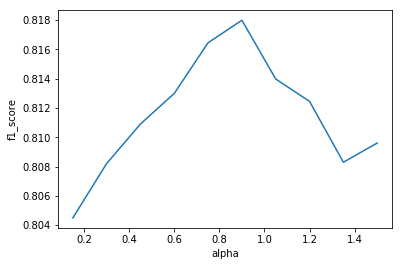

In [17]:
sample = train_df[0:5000]
n = int(2*len(sample)/3)
tfidf = TfidfVectorizer(ngram_range=(2,3), max_features=2500)
train_test = tfidf.fit_transform(sample['text'])
train_x = train_test[:n]
train_y = sample['label'].values[:n]
test_x = train_test[n:]
test_y = sample['label'].values[n:]

f1 = []
for i in range(10):
  clf = RidgeClassifier(alpha = 0.15*(i+1), solver = 'sag')
  clf.fit(train_x, train_y)
  val_pred = clf.predict(test_x)
  f1.append(f1_score(test_y, val_pred, average='macro'))

len(f1)
plt.plot([0.15*(i+1) for i in range(10)], f1)  # 对10个不同的alpha值的预测结果F1放到列表中，x轴每隔0.5，描一个y点。
plt.xlabel('alpha')
plt.ylabel('f1_score')
plt.show()

### 可以看出 正则化参数alpha不宜取的过大，也不宜过小。越小模型的拟合能力越强，泛化能力越弱，越大模型的拟合能力越差，泛化能力越强。

## 4.2 max_features对模型的影响
### 分别取max_features的值为1000、2000、3000、4000，研究max_features对模型精度的影响



RidgeClassifier(alpha=0.1, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='sag',
        tol=0.001)

RidgeClassifier(alpha=0.2, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='sag',
        tol=0.001)

RidgeClassifier(alpha=0.30000000000000004, class_weight=None, copy_X=True,
        fit_intercept=True, max_iter=None, normalize=False,
        random_state=None, solver='sag', tol=0.001)

RidgeClassifier(alpha=0.4, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='sag',
        tol=0.001)

Text(0.5,0,'max_features')

Text(0,0.5,'f1_score')

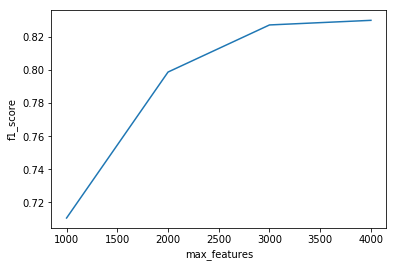

In [18]:
f1 = []
features = [1000,2000,3000,4000]
for i in range(4):
  tfidf = TfidfVectorizer(ngram_range=(2,3), max_features=features[i])
  train_test = tfidf.fit_transform(sample['text'])
  train_x = train_test[:n]
  train_y = sample['label'].values[:n]
  test_x = train_test[n:]
  test_y = sample['label'].values[n:]
  clf = RidgeClassifier(alpha = 0.1*(i+1), solver = 'sag')
  clf.fit(train_x, train_y)
  val_pred = clf.predict(test_x)
  f1.append(f1_score(test_y, val_pred, average='macro'))

plt.plot(features, f1)
plt.xlabel('max_features')
plt.ylabel('f1_score')
plt.show()

### 可以看出max_features越大模型的精度越高，但是当max_features超过某个数之后，再增加max_features的值对模型精度的影响就不是很显著了。



## 4.3 ngram_range对模型的影响
### n-gram提取词语字符数的下边界和上边界，考虑到中文的用词习惯，ngram_range可以在(1,4)之间选取
### ngram_range：tuple (min_n, max_n), default=(1, 1)
### For example an ngram_range of (1, 1) means only unigrams, (1, 2) means unigrams and bigrams, and (2, 2) means only bigrams.

In [19]:
f1 = []
tfidf = TfidfVectorizer(ngram_range=(1,1), max_features=3000)
train_test = tfidf.fit_transform(sample['text'])
train_x = train_test[:n]
train_y = sample['label'].values[:n]
test_x = train_test[n:]
test_y = sample['label'].values[n:]
clf = RidgeClassifier(alpha = 0.9, solver = 'sag')
clf.fit(train_x, train_y)
val_pred = clf.predict(test_x)
f1.append(f1_score(test_y, val_pred, average='macro'))

tfidf = TfidfVectorizer(ngram_range=(2,2), max_features=3000)
train_test = tfidf.fit_transform(sample['text'])
train_x = train_test[:n]
train_y = sample['label'].values[:n]
test_x = train_test[n:]
test_y = sample['label'].values[n:]
clf = RidgeClassifier(alpha = 0.9, solver = 'sag')
clf.fit(train_x, train_y)
val_pred = clf.predict(test_x)
f1.append(f1_score(test_y, val_pred, average='macro'))

tfidf = TfidfVectorizer(ngram_range=(3,3), max_features=3000)
train_test = tfidf.fit_transform(sample['text'])
train_x = train_test[:n]
train_y = sample['label'].values[:n]
test_x = train_test[n:]
test_y = sample['label'].values[n:]
clf = RidgeClassifier(alpha = 0.9, solver = 'sag')
clf.fit(train_x, train_y)
val_pred = clf.predict(test_x)
f1.append(f1_score(test_y, val_pred, average='macro'))

tfidf = TfidfVectorizer(ngram_range=(1,3), max_features=3000)
train_test = tfidf.fit_transform(sample['text'])
train_x = train_test[:n]
train_y = sample['label'].values[:n]
test_x = train_test[n:]
test_y = sample['label'].values[n:]
clf = RidgeClassifier(alpha = 0.9, solver = 'sag')
clf.fit(train_x, train_y)
val_pred = clf.predict(test_x)
f1.append(f1_score(test_y, val_pred, average='macro'))

RidgeClassifier(alpha=0.9, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='sag',
        tol=0.001)

RidgeClassifier(alpha=0.9, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='sag',
        tol=0.001)

RidgeClassifier(alpha=0.9, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='sag',
        tol=0.001)

RidgeClassifier(alpha=0.9, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='sag',
        tol=0.001)

In [20]:
print(f1)
# [0.8327864892462075, 0.8262101766905119, 0.713329559323366, 0.8491220528051281]
# ngram取unigram至trigram，即（1,3）效果最高

[0.8327864892462075, 0.8262101766905119, 0.713329559323366, 0.8491220528051281]


In [22]:
# 实验部分
# 综合最优参数alpha,max_features,ngram_range组合试一下模型
tfidf = TfidfVectorizer(ngram_range=(1,4),analyzer='char')
#X2 = tfidf.fit_transform(corpus)
print(vectorizer2.get_feature_names())  # 返回list
print(X2.toarray())

NameError: name 'corpus' is not defined

In [38]:
# 读取数据看原始样本，以及特征处理后的表示 看看
train_df = pd.read_csv('./data/train_set.csv', sep='\t', nrows=15000)
sample = train_df[:10]  # 采样部分原始数据
print(sample)

# 用Count
# Count = CountVectorizer(ngram_range=(1,4),analyzer='word')
# 由于原始数据，已经做了字符级处理，用空格分开每隔字符，每个字用索引值表示。因此只需进行word级别即可。
# tfidf = TfidfVectorizer(ngram_range=(1,4),analyzer='char',max_features=10000)
tfidf = TfidfVectorizer(ngram_range=(1,4),analyzer='word')   # ngram范围1~4 ngram级别word ngram特征数 10000


tfidf.fit_transform(sample['text'])

# 训练集是以tfidf方式提取特征的训练数据
train_test = tfidf.fit_transform(sample['text'])

# 如果不限制构建Vectorizer指定特征的数量，那么前5个样本有11820个标签，前10个样本有19228个标签
print(len(tfidf.get_feature_names()))
print(tfidf.get_feature_names())

   label                                               text
0      2  2967 6758 339 2021 1854 3731 4109 3792 4149 15...
1     11  4464 486 6352 5619 2465 4802 1452 3137 5778 54...
2      3  7346 4068 5074 3747 5681 6093 1777 2226 7354 6...
3      2  7159 948 4866 2109 5520 2490 211 3956 5520 549...
4      3  3646 3055 3055 2490 4659 6065 3370 5814 2465 5...
5      9  3819 4525 1129 6725 6485 2109 3800 5264 1006 4...
6      3  307 4780 6811 1580 7539 5886 5486 3433 6644 58...
7     10  26 4270 1866 5977 3523 3764 4464 3659 4853 517...
8     12  2708 2218 5915 4559 886 1241 4819 314 4261 166...
9      3  3654 531 1348 29 4553 6722 1474 5099 7541 307 ...
19228
['100', '100 3750', '100 3750 1613', '100 3750 1613 5864', '100 3750 3651', '100 3750 3651 5450', '100 3750 920', '100 3750 920 478', '100 7539', '100 7539 7191', '100 7539 7191 5165', '100 7539 7520', '100 7539 7520 6751', '1006', '1006 2058', '1006 2058 3912', '1006 2058 3912 628', '1006 3317', '1006 3317 7010', '1006 3317 7010 32

<10x19228 sparse matrix of type '<class 'numpy.float64'>'
	with 21382 stored elements in Compressed Sparse Row format>

RidgeClassifier(alpha=0.15, class_weight=None, copy_X=True,
        fit_intercept=True, max_iter=None, normalize=False,
        random_state=None, solver='sag', tol=0.001)

RidgeClassifier(alpha=0.3, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='sag',
        tol=0.001)

RidgeClassifier(alpha=0.44999999999999996, class_weight=None, copy_X=True,
        fit_intercept=True, max_iter=None, normalize=False,
        random_state=None, solver='sag', tol=0.001)

RidgeClassifier(alpha=0.6, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='sag',
        tol=0.001)

RidgeClassifier(alpha=0.75, class_weight=None, copy_X=True,
        fit_intercept=True, max_iter=None, normalize=False,
        random_state=None, solver='sag', tol=0.001)

RidgeClassifier(alpha=0.8999999999999999, class_weight=None, copy_X=True,
        fit_intercept=True, max_iter=None, normalize=False,
        random_state=None, solver='sag', tol=0.001)

RidgeClassifier(alpha=1.05, class_weight=None, copy_X=True,
        fit_intercept=True, max_iter=None, normalize=False,
        random_state=None, solver='sag', tol=0.001)

RidgeClassifier(alpha=1.2, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='sag',
        tol=0.001)

RidgeClassifier(alpha=1.3499999999999999, class_weight=None, copy_X=True,
        fit_intercept=True, max_iter=None, normalize=False,
        random_state=None, solver='sag', tol=0.001)

RidgeClassifier(alpha=1.5, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='sag',
        tol=0.001)

10

Text(0.5,0,'alpha')

Text(0,0.5,'f1_score')

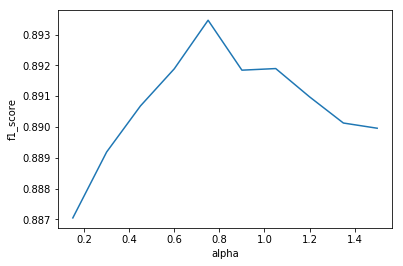

In [42]:
sample = train_df[0:15000]
n = int(2*len(sample)/3)

tfidf = TfidfVectorizer(ngram_range=(1,4),analyzer='word',max_features=10000)

train_test = tfidf.fit_transform(sample['text'])
train_x = train_test[:n]
test_x = train_test[n:]
train_y = sample['label'].values[:n]
test_y = sample['label'].values[n:]
f1 = []
for i in range(10):
    clf = RidgeClassifier(alpha = 0.15*(i+1), solver = 'sag')
    clf.fit(train_x, train_y)
    val_pred = clf.predict(test_x)
    f1.append(f1_score(test_y, val_pred, average='macro'))

len(f1)
plt.plot([0.15*(i+1) for i in range(10)], f1)  # 对10个不同的alpha值的预测结果F1放到列表中，x轴每隔0.5，描一个y点。
plt.xlabel('alpha')
plt.ylabel('f1_score')
plt.show()

In [43]:
print(f1)  # 10000个特征 15000条数据 最高准确率 89.34

[0.8870460418552523, 0.8891863715831381, 0.8906820911642567, 0.8918874203446956, 0.8934640491089623, 0.8918429018029322, 0.891895314314936, 0.8909771173409669, 0.8901272724950162, 0.8899578067319796]


# 五、考虑其他分类模型
### 特征提取使用TF-IDF，与第三节中TF-IDF + RidgeClassifier的特征提取保持一致，再来看下其他几种分类算法的效果。
## 5.1 LogisticRegression
### LogisticRegression的目标函数为：




In [44]:
## logistic回归  F1 84.64
from sklearn import linear_model


tfidf = TfidfVectorizer(ngram_range=(1,3), max_features=5000)
train_test = tfidf.fit_transform(train_df['text']) # 词向量 15000*max_features  原始数据共1.5w条数据

reg = linear_model.LogisticRegression(penalty='l2', C=1.0,solver='liblinear')
reg.fit(train_test[:10000], train_df['label'].values[:10000])

val_pred = reg.predict(train_test[10000:])
print('预测结果中各类新闻数目')
print(pd.Series(val_pred).value_counts())  # 输出预测值的统计数据
print('\n F1 score为')
print(f1_score(train_df['label'].values[10000:], val_pred, average='macro'))


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

预测结果中各类新闻数目
0     1032
1     1029
2      782
3      588
4      375
5      316
6      224
8      166
7      161
9      123
10     109
11      60
12      23
13      12
dtype: int64

 F1 score为
0.8464704900433653


In [45]:
## RidgeClassifier 岭回归分类器  F1 88.67
from sklearn import linear_model


tfidf = TfidfVectorizer(ngram_range=(1,3), max_features=5000)
train_test = tfidf.fit_transform(train_df['text']) # 词向量 15000*max_features  原始数据共1.5w条数据

ridge = linear_model.RidgeClassifier(alpha=0.9,solver='sag')
ridge.fit(train_test[:10000], train_df['label'].values[:10000])
val_pred = ridge.predict(train_test[10000:])
print('预测结果中各类新闻数目')
print(pd.Series(val_pred).value_counts())  # 输出预测值的统计数据
print('\n F1 score为')
print(f1_score(train_df['label'].values[10000:], val_pred, average='macro'))



RidgeClassifier(alpha=0.9, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='sag',
        tol=0.001)

预测结果中各类新闻数目
0     1032
1     1029
2      782
3      588
4      375
5      316
6      224
8      166
7      161
9      123
10     109
11      60
12      23
13      12
dtype: int64

 F1 score为
0.8464704900433653


In [47]:
##  SGD分类器 随机梯度下降 F1值  0.8471370470841141
tfidf = TfidfVectorizer(ngram_range=(1,3), max_features=5000)
train_test = tfidf.fit_transform(train_df['text']) # 词向量 15000*max_features

sgd = linear_model.SGDClassifier(loss="log", penalty='l2', alpha=0.0001,l1_ratio=0.15)
sgd.fit(train_test[:10000], train_df['label'].values[:10000])

val_pred = sgd.predict(train_test[10000:])
print('预测结果中各类新闻数目')
print(pd.Series(val_pred).value_counts())
print('\n F1 score为')
print(f1_score(train_df['label'].values[10000:], val_pred, average='macro'))


C:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

预测结果中各类新闻数目
1     1032
0     1019
2      782
3      583
4      377
5      319
6      225
8      162
7      160
9      128
10     111
11      63
12      28
13      11
dtype: int64

 F1 score为
0.8471370470841141


In [48]:
## SVM F1 值 0.8842406959433029
from sklearn import svm
tfidf = TfidfVectorizer(ngram_range=(1,3), max_features=5000)
train_test = tfidf.fit_transform(train_df['text']) # 词向量 15000*max_features

reg = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto',decision_function_shape='ovr')
reg.fit(train_test[:10000], train_df['label'].values[:10000])

val_pred = reg.predict(train_test[10000:])
print('预测结果中各类新闻数目')
print(pd.Series(val_pred).value_counts())
print('\n F1 score为')
print(f1_score(train_df['label'].values[10000:], val_pred, average='macro'))


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

预测结果中各类新闻数目
1     1011
0     1011
2      767
3      577
4      370
5      321
6      227
7      177
8      170
9      141
10     114
11      61
12      35
13      18
dtype: int64

 F1 score为
0.8842406959433029
